In [ ]:
import pickle
import random
import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Embedding,Dense,Dropout,Input,Concatenate,Conv1D,Flatten,MaxPooling1D,LSTM,Masking,Reshape
from keras.layers import Conv2D,MaxPooling2D,Bidirectional
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import keras.backend as K
import re, glob,os
from collections import defaultdict
import tensorflow as tf

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )

def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    """Build Text vectorization layer

    Args:
      texts (list): List of string i.e input texts
      vocab_size (int): vocab size
      max_seq (int): Maximum sequence lenght.
      special_tokens (list, optional): List of special tokens. Defaults to ['[MASK]'].

    Returns:
        layers.Layer: Return TextVectorization Keras Layer
    """
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)

    # Insert mask token in vocabulary
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer

def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()

def get_masked_input_and_labels(encoded_texts):
    # 20% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.2
    # Do not mask special tokens
    inp_mask[encoded_texts <= 3] = False
    # Set targets to -1 by default, it means ignore
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # Set input to [MASK] which is the last token for the 90% of tokens
    # This means leaving 10% unchanged
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[
        inp_mask_2mask
    ] = mask_token_id  # mask token is the last in the dict

    # Set 10% to a random token
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Prepare sample_weights to pass to .fit() method
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights

def bert_module(query, key, value, i):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc


loss_fn = keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE
)
loss_tracker = tf.keras.metrics.Mean(name="loss")

class MaskedLanguageModel(tf.keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker]

class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)
def elemVectorize(inpt):
    dat=np.zeros((len(inpt),config.MAX_LEN),dtype=int)
    for i,j in enumerate(inpt):
        if len(j)>=config.MAX_LEN:
            rndN=np.random.randint(0,config.MAX_LEN-1)
        elif len(j)<2:
            rndN=0
        else:
            rndN=np.random.randint(0,len(j)-1)
        for i0,j0 in enumerate(j[:config.MAX_LEN]):
            dat[i,i0]=element2id.get(j0)
        dat[i,rndN]=element2id.get('[MASK]')
    return dat


def unison_shuffled_copies(a,b,c):
    assert len(a) == len(b)
    anew, bnew, cnew =[], [], []
    for i,j,k in zip(a,b,c):
        p = np.random.permutation(i.shape[0])
        anew.append(i[p])
        bnew.append(j[p])
        cnew.append(k[p])
    return anew, bnew, cnew


def decode(tokens):
        return [id2element[t] for t in tokens if t != 0]

def convert_ids_to_tokens(id):
    return id2element[id]

def norm(x_train0):
    scaler = MinMaxScaler().fit(x_train0[np.any(x_train0, -1)])
    x_train0[np.any(x_train0, -1)] = scaler.transform(x_train0[np.any(x_train0, -1)])
    return x_train0
def storePickle(data,names,fname):
    db = {}
    for i,j in zip(data,names):
        db[j] = i
    with open(fname, 'wb') as dbfile:
        pickle.dump(db, dbfile)
    return db

def loadData(fname,printkeys='y'):
    # for reading also binary mode is important
    dbfile = open(fname, 'rb')     
    db = pickle.load(dbfile)
    if printkeys=='y':
        for keys in db:
            print(keys)
    return db

def sortElements(types):
    deco = sorted([(tag, i) for i, tag in enumerate(types)])
    indices = [i for tag, i in deco]
    return indices

def sortData(types,x1,x2):
    inds = [sortElements(i) for i in types]
    types0=[]
    for i,j in enumerate(types):
        if isinstance(j, pd.Series):
            j1 = j.to_list()
            types0.append([j1[k] for k in inds[i]])
        else:
            types0.append([j[k] for k in inds[i]])            
    #types = [j[inds[i]] for i,j in enumerate(types)]
    x01 = [j[inds[i]] for i,j in enumerate(x1)]
    x02 = [j[inds[i]] for i,j in enumerate(x2)]
    return types0,x01,x02

def preprocElements(types):
    '''
    Nb0+      ---> Nb
    Nb3+      ---> Nb3+
    Nb4.875+  ---> Nb4+
    
    '''
    for i,j in enumerate(types):
        if '.' in j:
            oxold = re.findall("\d+\.\d+", types[i])[0]
            oxnew = round(float(oxold))
            if oxnew==0:
                types[i]=j.replace(oxold,'').replace('+','').replace('-','')
            else:
                types[i]=j.replace(oxold,str(oxnew))
        elif '0+' in j: #('0+' in j) | ('+' in j):
            types[i] = j.replace('0+','')
        elif '0-' in j: #('0+' in j) | ('+' in j):
            types[i] = j.replace('0-','')
    return types
def createTrainData(typesC,racsfC,aacsfC,element2id,MAX_LEN):
    typesF, dat0, dat1 = typesC,racsfC,aacsfC
    check=[]
    typesNumerical=[]
    for i in typesF:
        typesNumerical.append([element2id[j] for j in i])
    x0 = tf.keras.preprocessing.sequence.pad_sequences(dat0,dtype='float64',padding= 'post',maxlen=MAX_LEN )
    x1 = tf.keras.preprocessing.sequence.pad_sequences(dat1,dtype='float64',padding= 'post',maxlen=MAX_LEN )
    y = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int64',padding= 'post',maxlen=MAX_LEN)
    x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(y)
    return x0,x1,x_masked_train, y_masked_labels, sample_weights



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
class Config:
    MAX_LEN = 128
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 128
    NUM_HEAD = 4  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1
    MNAME = 'embed_rdf_pretrain_'
config = Config()
path="/content/gdrive/MyDrive/e3nn/"
mname=path+config.MNAME+'E_'+str(config.EMBED_DIM)+'_H_'+str(config.NUM_HEAD)+'_L_'+str(config.NUM_LAYERS)
tf.random.set_seed(42)

In [ ]:
mname

'/content/gdrive/MyDrive/e3nn/embed_rdf_pretrain_E_128_H_4_L_1'

In [ ]:
!pip install ase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load data from Pickle

In [ ]:
for fname in ['pymatgen_rdf_data.pkl']:
    data_dict = loadData(path+fname,printkeys='y')

formula
ids
types
xyz
cell
k2atoms


In [ ]:
#types = [['[CLS]']+i+['[SEP]'] for i in data_dict['types']]
#formula = data_dict['formula']
#ids = data_dict['ids']
#xyz = data_dict['xyz']
#cell=data_dict['cell']
#edos=data_dict['dos']
#x1 = [np.vstack((np.ones(100),j,np.zeros(100))) for j in data_dict['k2atoms']]
#x2 = [np.vstack((np.ones(100),j,np.zeros(100))) for j in data_dict['k3atoms']]


In [ ]:
# Load data for masked language model
Vocab = sorted(list(set([j for i in data_dict['types'] for j in i]))) # uniqueTypes                    
Vocab.insert(0,'[CLS]')                     
Vocab.insert(0,'[SEP]')                         
Vocab.insert(0,'[UNK]') 
Vocab.insert(0,'')      
Vocab.append('[MASK]')  
element2id = dict(zip(Vocab, np.arange(len(Vocab))))
element2id = defaultdict(lambda: 1, element2id)
id2element = {y: x for x, y in element2id.items()}
len(Vocab)
config.VOCAB_SIZE = len(element2id)
mask_token_id = element2id['[MASK]']


In [ ]:
config.VOCAB_SIZE

93

In [ ]:
typesNumerical=[]
for i in data_dict['types']:
    typesNumerical.append([element2id[j] for j in i])

x1 = tf.keras.preprocessing.sequence.pad_sequences(data_dict['k2atoms'],dtype='float32',padding= 'post',maxlen=config.MAX_LEN )
#x2 = tf.keras.preprocessing.sequence.pad_sequences(x2,dtype='float32',padding= 'post',maxlen=config.MAX_LEN )
x1[np.isnan(x1)]=0
x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',maxlen=config.MAX_LEN)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(x3)

In [ ]:
del data_dict

# Predict types
I shall use x_train2 as y_train but after replacing 20% of atoms with 0

In [ ]:
def create_masked_language_bert_model(inputs):
    word_embeddings = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputs)
    position_embeddings = layers.Embedding(input_dim=config.MAX_LEN,output_dim=config.EMBED_DIM,
                                           weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
                                           name="position_embedding",)(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)
    #mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(encoder_output)
    mlm_model = Model(inputs, encoder_output, name="masked_bert_model")

    return mlm_model

In [ ]:
inputA = Input(shape=x1.shape[1:],name='x1')
#inputB = Input(shape=x2.shape[1:],name='x2')
inputC = Input((config.MAX_LEN), dtype=tf.int32,name='types')

# the first branch operates on the first input
x = Masking(mask_value=0)(inputA)
x = Bidirectional(LSTM(8,name='x1_lstm',return_sequences=True),name='x1_blstm')(x)
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
#y = Masking(mask_value=0)(inputB)
#y = Bidirectional(LSTM(16,name='x2_lstm',return_sequences=True),name='x2_blstm')(y)
#y = Model(inputs=inputB, outputs=y)

z =  layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputC)
z = Model(inputs=inputC, outputs=z)
combined = Concatenate()([x.output,z.output])

e = Dense(512, activation="relu",use_bias=True)(combined)
#e = LSTM(config.VOCAB_SIZE)(combined)
e = Dense(config.VOCAB_SIZE, activation="softmax")(e)
# our model will accept the inputs of the three branches and then output a single value
model = MaskedLanguageModel(inputs=[x.input,z.input], outputs=e)

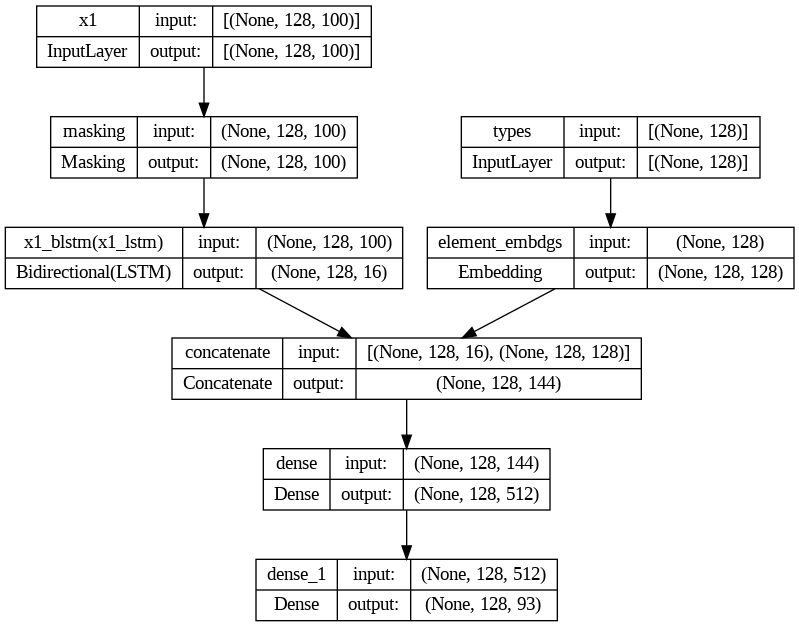

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True,to_file=mname+".png")

In [ ]:
model.summary()

Model: "masked_language_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x1 (InputLayer)                [(None, 128, 100)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 128, 100)     0           ['x1[0][0]']                     
                                                                                                  
 types (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 x1_blstm (Bidirectional)       (None, 128, 16)      6976        ['masking[0][0]']                
                                                                              

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=config.LR)
model.compile(optimizer=optimizer)
#model.load_weights(mname+".h5")

In [ ]:
if os.path.isfile(mname+"_log.csv"):
    df = pd.read_csv(mname+"_log.csv")
    initEp = df['epoch'].to_numpy()[-1]+1
    model.load_weights(mname+".h5")
else:
    initEp = 0
epochs=50*config.BATCH_SIZE
csv_logger = keras.callbacks.CSVLogger(mname+"_log.csv", append=True)
checkpoint = keras.callbacks.ModelCheckpoint(mname+".h5",verbose=1, mode='min',save_freq=5000)
callbacks_list = [checkpoint,csv_logger]
hist = model.fit([x1,x_masked_train],y_masked_labels,
                 sample_weight=sample_weights, initial_epoch=initEp,
                 epochs=epochs, callbacks = callbacks_list,batch_size=config.BATCH_SIZE)
model.save(mname+".h5")

Epoch 162/1600
1767/1767 [==============================] - 47s 20ms/step - loss: 0.9727
Epoch 163/1600
1767/1767 [==============================] - 35s 20ms/step - loss: 0.9147
Epoch 164/1600
1465/1767 [=======================>......] - ETA: 5s - loss: 0.8931
Epoch 164: saving model to /content/gdrive/MyDrive/e3nn/embed_rdf_pretrain_E_128_H_4_L_1.h5
1767/1767 [==============================] - 33s 19ms/step - loss: 0.8928
Epoch 165/1600
1767/1767 [==============================] - 33s 19ms/step - loss: 0.8759
Epoch 166/1600
1767/1767 [==============================] - 35s 20ms/step - loss: 0.8651
Epoch 167/1600
1162/1767 [==================>...........] - ETA: 11s - loss: 0.8441
Epoch 167: saving model to /content/gdrive/MyDrive/e3nn/embed_rdf_pretrain_E_128_H_4_L_1.h5
1767/1767 [==============================] - 33s 19ms/step - loss: 0.8536
Epoch 168/1600
1767/1767 [==============================] - 33s 19ms/step - loss: 0.8451
Epoch 169/1600
1767/1767 [==============================

In [ ]:
model.save(mname+".h5")

In [ ]:
plt.plot(hist.history['loss'],linewidth=2)

In [ ]:
db_test = loadData('/mnt/c/Users/User/DataScience/chemML/mat2spec/mat2spec_ordered20k.pkl')
x_train0_test,x_train1_test = norm(db_test['x1']),norm(db_test['x2'])
types_test = db_test['types']

In [ ]:
x_train0_test = tf.keras.preprocessing.sequence.pad_sequences(x_train0_test,dtype='float',padding= 'post',maxlen=config.MAX_LEN )
x_train1_test = tf.keras.preprocessing.sequence.pad_sequences(x_train1_test,dtype='float',padding= 'post',maxlen=config.MAX_LEN )

In [ ]:
%%time
count_test=0
num=1000
p = np.random.permutation(x_train0_test.shape[0])
correlation=np.zeros((2,num))
for i0,i1 in enumerate(p[:num]):
    sample_tokens=elemVectorize(types_test[i1:i1+1])
    prediction=model.predict([x_train0_test[i1:i1+1],x_train1_test[i1:i1+1],sample_tokens],verbose=0)
    masked_index = np.where(sample_tokens == mask_token_id)
    masked_index = masked_index[1]
    mask_prediction = prediction[0][masked_index]
    top_indice = mask_prediction[0].argsort()[-1:][::-1]
    values = mask_prediction[0][top_indice]
    count_test+=np.sum(convert_ids_to_tokens(top_indice[0])==types_test[i1][masked_index[0]])
    correlation[0,i0]=top_indice[0]
    correlation[1,i0]=element2id[types_test[i1][masked_index[0]]]
    #print("pred: ",convert_ids_to_tokens(top_indice[0]),"orig: ",types_test[i1][masked_index[0]])
print('Bidirectional_Score: ', count_test/num)

In [ ]:
%%time
count_test=0
num=1000
p = np.random.permutation(x_train0_test.shape[0])
correlation=np.zeros((2,num))
for i0,i1 in enumerate(p[:num]):
    sample_tokens=elemVectorize(types_test[i1:i1+1])
    prediction=model.predict([x_train0_test[i1:i1+1],x_train1_test[i1:i1+1],sample_tokens],verbose=0)
    masked_index = np.where(sample_tokens == mask_token_id)
    masked_index = masked_index[1]
    mask_prediction = prediction[0][masked_index]
    top_indice = mask_prediction[0].argsort()[-1:][::-1]
    values = mask_prediction[0][top_indice]
    count_test+=np.sum(convert_ids_to_tokens(top_indice[0])==types_test[i1][masked_index[0]])
    correlation[0,i0]=top_indice[0]
    correlation[1,i0]=element2id[types_test[i1][masked_index[0]]]
    #print("pred: ",convert_ids_to_tokens(top_indice[0]),"orig: ",types_test[i1][masked_index[0]])
print('Score: ', count_test/num)

In [ ]:
plt.scatter(correlation[0,:],correlation[1,:])

In [ ]:
mask_prediction[0].argsort()[-1:][::-1]

In [ ]:
fig = plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
plt.plot(hist.history['loss'],linewidth=2)
plt.legend((["Score: "+str(count/num)+'; Test score: '+str(count_test/num)]))
plt.title("bert_Element_mlm_"+str(config.EMBED_DIM)+config.MNAME)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.savefig(path+"bert_Element_mlm_"+str(config.EMBED_DIM)+config.MNAME+'_loss.png',format='png',
            dpi=800,bbox_inches='tight',pil_kwargs={"compression": "tiff_lzw"})

In [ ]:
x_train0.shape

In [ ]:
u=np.random.randint(1,len(types)-1)
u1=u-1
sample_tokens=elemVectorize(types[u1:u])
prediction=model.predict([x_train0[u1:u],x_train1[u1:u],sample_tokens])

k=5

masked_index = np.where(sample_tokens == mask_token_id)
masked_index = masked_index[1]
mask_prediction = prediction[0][masked_index]

top_indices = mask_prediction[0].argsort()[-k:][::-1]
values = mask_prediction[0][top_indices]
for i in range(len(top_indices)):
    p = top_indices[i]
    v = values[i]
    tokens = np.copy(sample_tokens[0])
    tokens[masked_index[0]] = p
    result = {        
#        "input_text": decode(sample_tokens[0]),
#        "prediction": decode(tokens),
        "probability": v,
        "predicted mask token": convert_ids_to_tokens(p),
        "original token": types[u1][masked_index[0]]
    }
    print(result)
    
    #print("probability",v,"predicted_mask_token",convert_ids_to_tokens(p),"orig_token",list(types[u][masked_index])[0])

In [ ]:
convert_ids_to_tokens(p)

In [ ]:
hidden_features = model.predict([x_train0,x_train1,x_masked_train])

In [ ]:
hidden_features0=hidden_features.reshape(hidden_features.shape[0],hidden_features.shape[1]*hidden_features.shape[2])

In [ ]:
tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(hidden_features0) ## Reduced for computational issues
colors_map = np.argmax(y_train, axis=1)

In [ ]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d   

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = np.array([x for x in 'b-g-r-c-m-y-k-purple-coral-lime'.split('-')])
colors_map0 = colors_map
plt.figure(figsize=(10,10))
for cl in np.unique(colors_map0):
    indices = np.where(colors_map0==cl)
    ax.scatter(X_tsne[indices,0], X_tsne[indices, 1],X_tsne[indices, 2], label=cl)
#plt.legend()
#plt.show()
ax.grid(False)

In [ ]:
np.unique(colors_map0)

In [ ]:
plt.scatter(trans_data[:,0][0:mid], trans_data[:,1][0:mid], trans_data[:,2][0:mid], c= 'r', s = 100, marker='+')
plt.scatter(trans_data[:,0][mid:], trans_data[:,1][mid:], trans_data[:,2][mid:], c= 'b', s = 100, marker='.')

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne[indices,0], X_tsne[indices, 1],X_tsne[indices, 2], c=colors[cl], label=cl)
ax.grid(False)

In [ ]:
import tensorflow as tf

# Write
a = tf.zeros((100, 512), tf.int32)
ds = tf.data.Dataset.from_tensor_slices((a, a, a, a[:, 0])).batch(32)
for i, _ in enumerate(ds.element_spec):
    ds_i = ds.map(lambda *args: args[i]).map(tf.io.serialize_tensor)
    writer = tf.data.experimental.TFRecordWriter(f'mydata.{i}.tfrecord')
    writer.write(ds_i)

# Read
NUM_PARTS = 4
parts = []
def read_map_fn(x):
    return tf.io.parse_tensor(x, tf.int32)
for i in range(NUM_PARTS):
    parts.append(tf.data.TFRecordDataset(f'mydata.{i}.tfrecord').map(read_map_fn))
ds = tf.data.Dataset.zip(tuple(parts))
print(ds)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
tf.data.experimental.save(tf.data.Dataset.from_tensor_slices(
    tf.concat([x_train10,x_train11,x_train12], 0, name='concat')).batch(32),path+'mydata_train.tfrecord')



In [ ]:
#mlm_ds = tf.data.Dataset.from_tensor_slices(((x_train0,x_train1,x_masked_train), y_masked_labels, sample_weights))

#mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

In [ ]:
"""
Permutation Invariant Neural Network Layer
================================================================================
Core functions and classes.
"""

import keras
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Conv2D, Lambda
from keras.models import Sequential
import numpy as np
import tensorflow as tf


def PermutationInvariant(input_shape, layer_sizes, tuple_dim = 2, reduce_fun = "mean"):
    """
    Implements a permutation invariant layer.
    Each batch in our data consists of `input_shape[0]` observations
    each with `input_shape[1]` features.
    Args:
    input_shape -- A pair of `int` - (number of observations in one batch x
        number of features of each observation). The batch dimension is not included.
    layer_sizes -- A `list` of `int`. Sizes of layers in the dense neural network applied
        to each tuple of observations.
    tuple_dim -- A `int`, how many observations to put in one tuple.
    reduce_fun -- A `string`, type of function to "average" over all tuples.
    Returns:
    g -- A `Sequential` keras container - the permutation invariant layer.
        It consists of one tupple layer that creates all possible `tuple_dim`-tuples
        of observations. On each tuple is applied the same dense neural network
        and then some symmetric pooling function is applied across all of them
        (for example mean or maximum).
    """
    g = Sequential()

    ## Tuple layer
    g.add(Tuples(tuple_dim, input_shape = input_shape))  ## out shape: batch_size x rows x cols

    ## Dense neural net -- implemented with conv layers
    g.add(Lambda(lambda x : K.expand_dims(x, axis = 2))) ## out shape: batch_size x rows x 1 x cols
    for layer_size in layer_sizes:
        g.add(Conv2D(filters = layer_size, kernel_size = (1,1), data_format = "channels_last")) ## out_shape:  batch_size x rows x 1 x layer_size
    g.add(Lambda(lambda x : K.squeeze(x, axis = 2))) ## lout_shape: batch_size x rows x cols

    ## Pooling layer
    if reduce_fun == "mean":
        lambda_layer = Lambda(lambda x : K.mean(x, axis = 1))
    elif reduce_fun == "max":
        lambda_layer = Lambda(lambda x : K.max(x, axis = 1))
    else:
        raise ValueError("Invalid value for argument `reduce_fun` provided. ")
    g.add(lambda_layer) ## out shape: batch_size x cols

    return g


class Tuples(Layer):
    """
    Creates all possible tuples of rows of 2D tensor.
    In the case of tuple_dim = 2, from one input batch:
        x_1,
        x_2,
        ...
        x_n,
    where x_i are rows of the tensor, it creates 2D output tensor:
        x_1 | x_1
        x_1 | x_2
        ...
        x_1 | x_n
        x_2 | x_1
        x_2 | x_2
        ...
        x_2 | x_n
        ...
        x_n | x_n
    Args:
    tuple_dim -- A `int`. Dimension of one tuple (i.e. how many rows from the input
    tensor to combine to create a row in output tensor)
    input_shape -- A `tuple` of `int`. In the most frequent case where our data
        has shape (batch_size x num_rows x num_cols) this should be (num_rows x num_cols).
    """

    def __init__(self, tuple_dim = 2, **kwargs):
        self.tuple_dim = tuple_dim
        super(Tuples, self).__init__(**kwargs)

    def create_indices(self, n, k = 2):
        """
        Creates all integer valued coordinate k-tuples in k dimensional hypercube with edge size n.
        for example n = 4, k = 2
        returns [[0, 0], [0, 1], [0, 2], [0, 3],
                 [1, 0], [1, 1], [1, 2], [1, 3],
                 ...
                 [3, 0], [3, 1], [3, 2], [3, 3]]
        Args:
        n -- A `int`, edge size of the hypercube.
        k -- A `int`, dimension of the hypercube.
        Returns:
        indices_n_k -- A `list` of `list` of `int`. Each inner list represents coordinates of one integer point
            in the hypercube.
        """
        if k == 0:
            indices_n_k = [[]]
        else:
            indices_n_k_minus_1 = self.create_indices(n, k-1)
            indices_n_k = [[i] + indices_n_k_minus_1[c] for i in range(n) for c in range(n**(k-1))]

        return indices_n_k

    def build(self, input_shape):
        # Create indexing tuple
        self.gathering_indices = self.create_indices(input_shape[-2], self.tuple_dim)
        super(Tuples, self).build(input_shape)  # Be sure to call this somewhere!


    def call(self, x):
        stack_of_tuples = K.map_fn(
            fn = lambda z :
                K.concatenate(
                    [K.reshape(
                        K.gather(z, i),
                        shape = (1,-1)
                     )
                     for i in self.gathering_indices
                    ],
                    axis = 0
                ),
            elems = x
        )
        return stack_of_tuples


    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] = output_shape[-1] * self.tuple_dim
        output_shape[-2] = output_shape[-2] ** self.tuple_dim
        return tuple(output_shape)


if __name__ == "__main__":
    tuple_dim = 2
    inp_shape = (5,3,2)

    ############################################################################
    ## TESTING Tuples LAYER

    ## Create graph
    ## Input data, 32 experiments in batch, 7 observations in each experiment, 5 feature columns
    tf.compat.v1.disable_eager_execution()
    data = tf.compat.v1.placeholder(shape = inp_shape, dtype = tf.float32)
    tuples_layer = Tuples(tuple_dim = tuple_dim, input_shape = inp_shape[1:])
    data_tup = tuples_layer(data)

    ## Run for concrete example
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    np.random.seed(0)
    feed = {data : np.random.randn(*inp_shape)}
    data_eval, data_tup_eval = sess.run([data, data_tup], feed)

    print("-------------------------------------------------------------------")
    print("A) Testing Tuples Layer:")
    print("Tuple dimension is: ", tuple_dim)
    print("Data shape is -- (batch size x num rows x num cols): ", data.shape)
    print("Transformed data shape is -- (batch size x num rows ** tuple size, num cols * tuple size): ", data_tup.shape)
    print("Data value is: ", data_eval)
    print("Transformed data value is:", data_tup_eval)
    ##
    ############################################################################


    ############################################################################
    ## TESTING PermutationInvariant
    layer_sizes = [5, 9, 8, 6]
    perm_inv = PermutationInvariant(input_shape = inp_shape[1:],
                                    layer_sizes = layer_sizes,
                                    tuple_dim = tuple_dim,
                                    reduce_fun = "mean")

    data_perm_inv = perm_inv(data)

    print("-------------------------------------------------------------------")
    print("B) Testing permutation_invariant function:")
    print("Data is the same as in A).")
    print("Shape of permutation invariant layer output: ", data_perm_inv.shape)
    ##
    ############################################################################